# Exploratory Analysis of Water Quality Data II - Continuous Data

# Sampling Location

This document includes Python code and results of the exploratory analysis of water quality data in the SEACAR Pilot project.

In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors
import numpy      as np
import pandas     as pd
import geopandas  as gpd
import contextily as cx
import seaborn    as sns
import warnings
warnings.filterwarnings('ignore')

## 1. Data loading and preprocessing
Read the csv file and shapefile of managed areas.

In [2]:
df      = pd.read_csv("OEAT_Continuous-2022-Nov-04.csv")
areaShp = gpd.read_file("ORCP_Managed_Areas_Oct2021.shp")

Select five managed areas and five parameters. Select only columns that are needed for the analysis. Convert the SampleDate from string to datetime object.

In [3]:
df2 = df.loc[df["ManagedAreaName"].isin(["Guana Tolomato Matanzas National Estuarine Research Reserve",
                            "Biscayne Bay Aquatic Preserve",
                            "Estero Bay Aquatic Preserve",
                            "Gasparilla Sound-Charlotte Harbor Aquatic Preserve",
                            "Big Bend Seagrasses Aquatic Preserve"])]
df2 = df2[['RowID','ParameterName','ParameterUnits','ProgramLocationID','ActivityType','ManagedAreaName',
           'SampleDate','Year','Month','ResultValue','ValueQualifier','Latitude_DD','Longitude_DD']]
df2 = df2.loc[df2["ParameterName"].isin(["Salinity","Total Nitrogen","Dissolved Oxygen","Turbidity","Secchi Depth"])]
df2["timestamp"]=  pd.to_datetime(df2['SampleDate'])

Remove outliers

In [4]:
# Remove total nitrogen outliers (>100)
df2.drop(df2[(df2['ParameterName'] == 'Total Nitrogen') & 
    (df2['ResultValue'] > 100)].index,inplace=True)

# Remove a single measurement in 1996-07-22 (RowID: 1582917)
df2.drop(df2[df2['RowID'] == 1582917].index, inplace=True)

# Remove turbidity outliers (>25)
df2.drop(df2[(df2['ParameterName'] == 'Turbidity') & 
    (df2['ResultValue'] > 25)].index, inplace=True)

# Remove Secchi Depth before 1995 (117 records)
df2.drop(df2[(df2['ParameterName'] == 'Secchi Depth') & 
    (df2['Year'] < 1995)].index, inplace=True)

Create lists of water quality parameters, lists of five managed areas and list of statistics to be calculated.

In [5]:
listPara = ["Salinity","Total Nitrogen","Dissolved Oxygen","Turbidity","Secchi Depth"] 
listArea = ["Guana Tolomato Matanzas National Estuarine Research Reserve",
                            "Biscayne Bay Aquatic Preserve",
                            "Estero Bay Aquatic Preserve",
                            "Gasparilla Sound-Charlotte Harbor Aquatic Preserve",
                            "Big Bend Seagrasses Aquatic Preserve" ]
listValue = ["count", "mean","max","min","std"]
dictUnits = {"Salinity":"ppt","Total Nitrogen": "mg/L","Dissolved Oxygen": "mg/L","Turbidity": "NTU", "Secchi Depth": "m"}
dictMonth = {1:"January",2:"February",3:"March",4:"April",5:"May",6:"June",7:"July",8:"August",
             9:"September",10:"October",11:"November",12:"December"}
dictArea = {'Gasparilla Sound-Charlotte Harbor Aquatic Preserve':'Charlotte Harbor','Big Bend Seagrasses Aquatic Preserve':'Big Bend',
            'Guana Tolomato Matanzas National Estuarine Research Reserve':'GTM Reserve','Estero Bay Aquatic Preserve':'Estero Bay',
            'Biscayne Bay Aquatic Preserve':'Biscayne Bay'}

## 2. Fixed and random sampling locations

This step is to calculate the sample location of Salinity in five areas and to calculate whether they are fixed points or random points.


### 2.1 Distribution of repeatitive samples at unique locations
First, aggregate the data by location and parameter name.

In [19]:
plt.rcParams['figure.figsize'] = [16, 8]

dfLoc  = df2.groupby(['Latitude_DD','Longitude_DD',"ParameterName","ManagedAreaName"])["ResultValue"].agg("count").reset_index()

dfLoc = dfLoc.rename(columns={"ResultValue": "samples"})

dfLoc.loc[dfLoc["samples"] == 1,['sample_type']] ='Random Point'
dfLoc.loc[dfLoc["samples"] > 1,['sample_type']] ='Fixed Point'

Plot histograms of samples at unique positions.

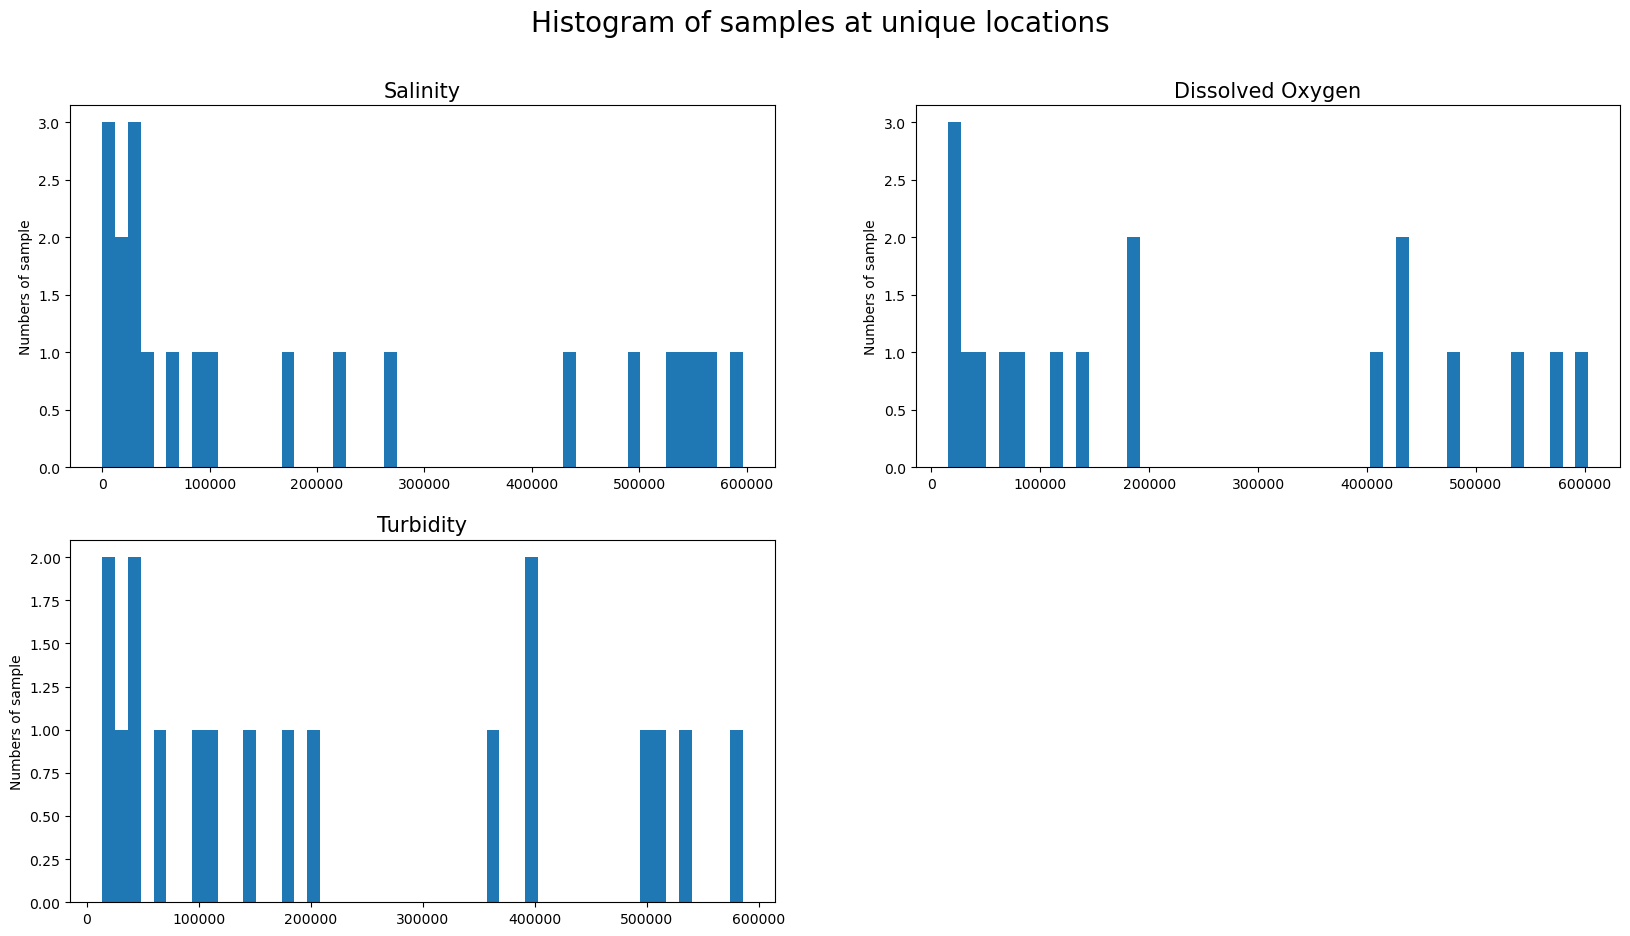

In [22]:
plt.rcParams['figure.figsize'] = [20, 16]

i = 0

fig = plt.figure()
plt.suptitle("Histogram of samples at unique locations", fontsize = 20, y = 0.94)

for para in listPara:
    dfNew = dfLoc[dfLoc['ParameterName']==para]
    if dfNew["ParameterName"].count() != 0:
        ax = fig.add_subplot(3,2,i+1)
        ax.set_title(para, size=15) # Title  
        ax.hist(dfNew["samples"],bins=50)
        i=i+1
        plt.ylabel("Numbers of sample")

### 2.2 Proportions of random  sampling (1 sample) and fixed sampling (>1 samples) locations 

Plot pie charts of fixed samples and random samples

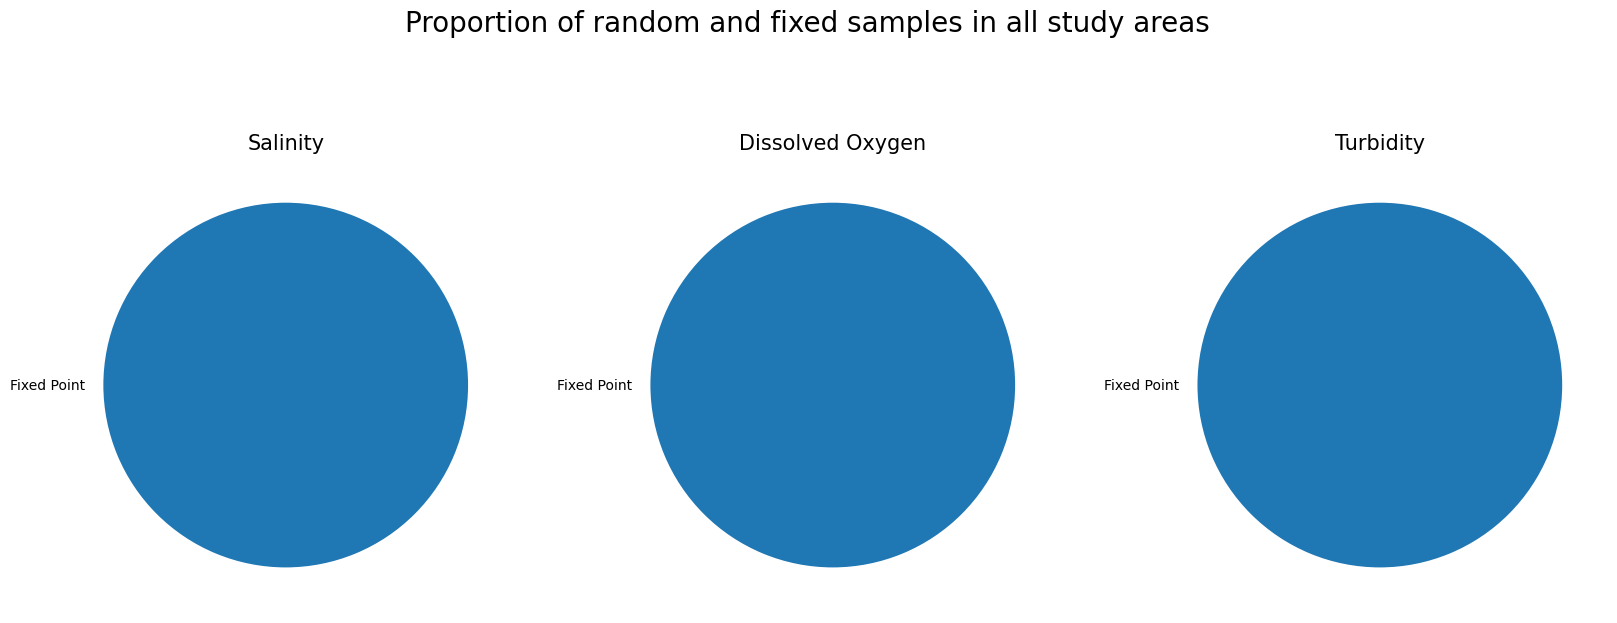

In [27]:
plt.rcParams['figure.figsize'] = [20, 16]
i = 0
fig = plt.figure()
plt.suptitle("Proportion of random and fixed samples in all study areas", fontsize = 20, y = 0.94)
for para in listPara:
    dfNew = dfLoc[dfLoc['ParameterName']==para]
    if dfNew['ParameterName'].count() != 0:
        dfNew_agg = dfNew.groupby(['sample_type'])['samples'].agg("count").reset_index()
        ax = fig.add_subplot(2,3,i+1)
        ax.set_title(para, size=15) # Title  
        ax.pie(x = dfNew_agg["samples"],labels = dfNew_agg["sample_type"])
        i=i+1

Create bar chart to show ratios of fixed sampling locations in five managed areas

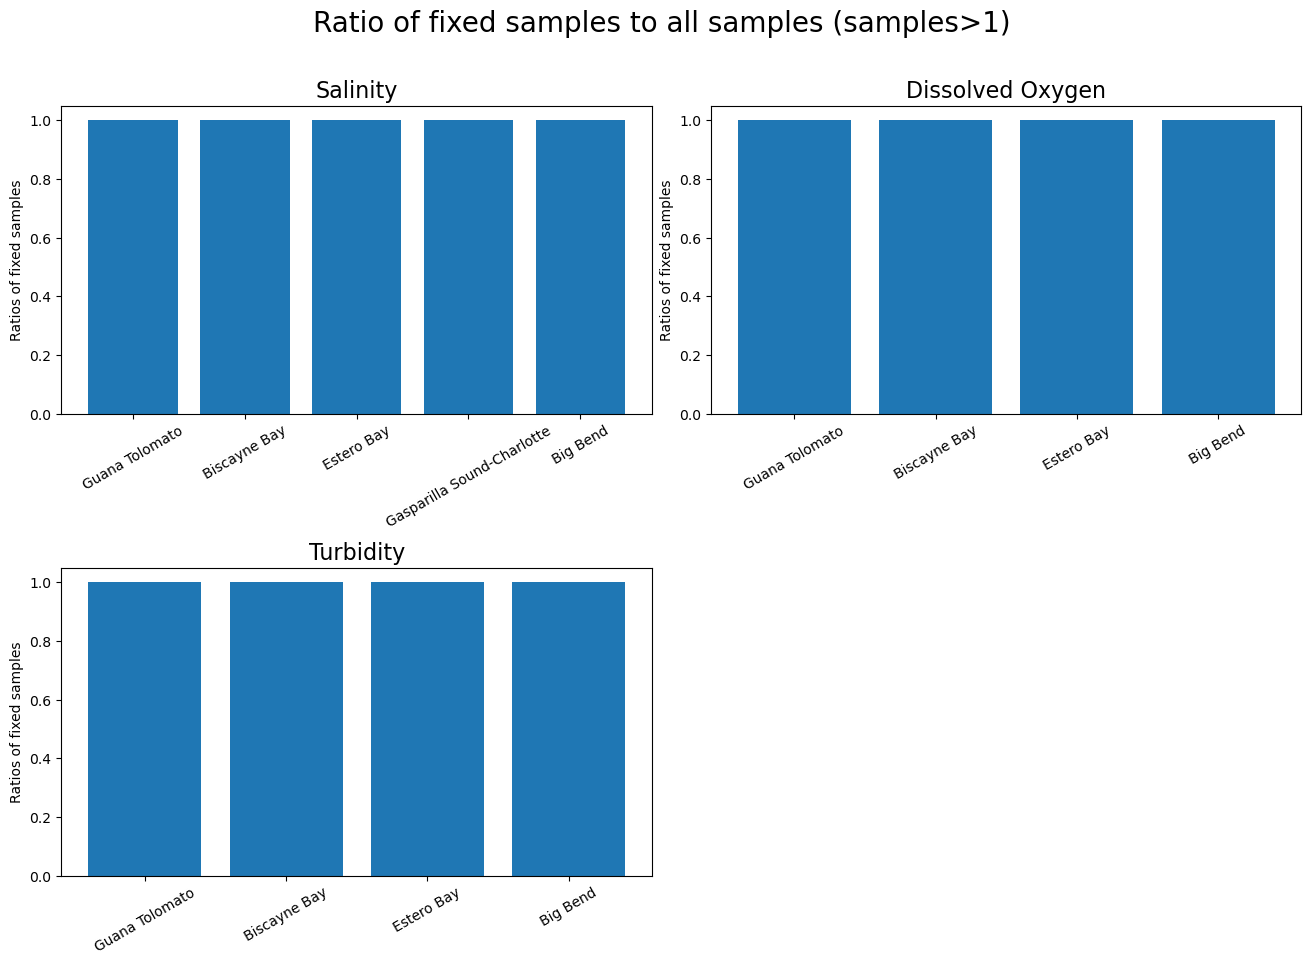

In [72]:
# This step is to calculate the ratios of fix points to total points in five areas.
fig = plt.figure(figsize = (16, 16))
plt.suptitle("Ratio of fixed samples to all samples (samples>1)", fontsize = 20, y = 0.94)
i = 0
for para in [listPara[0],listPara[2],listPara[3]]:
    list_ratio = []
    listArea_short = [] 
    for area in listArea:
        gdfLocPara = dfLoc[(dfLoc['ParameterName'] == para)&(dfLoc['ManagedAreaName'] == area)]
#         print(str(gdfLocPara["ParameterName"].count()) +" "+ para+" "+area )
        if gdfLocPara["ParameterName"].count() !=0:
            allPoints  = gdfLocPara.shape[0]
            fixedPoints = gdfLocPara.loc[gdfLocPara["sample_type"]=="Fixed Point"].shape[0]
            ratio      = round(fixedPoints/allPoints,4)
            list_ratio.append(ratio)
            listArea_short.append(area.split(' ')[0] + " "+ area.split(' ')[1])
    ax = fig.add_subplot(3,2,i+1)
    plt.bar(listArea_short,list_ratio)
    plt.title(para,size=16)
    plt.xticks(rotation=30)
    plt.ylabel("Ratios of fixed samples")
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.5)
    plt.show
    i=i+1

## 3 Spatial distribution of sampling locations

Convert sampling points of salinity to GeoDataFrame

In [34]:
# Group data by location, parametername and managed area name
gdfLoc = gpd.GeoDataFrame(dfLoc, geometry = gpd.points_from_xy(dfLoc.Longitude_DD, dfLoc.Latitude_DD), crs="EPSG:4326")


Plot sampling locations in all years.

### 3.1 Sampling locations of dissolved oxygen in all years

<Figure size 2000x1500 with 0 Axes>

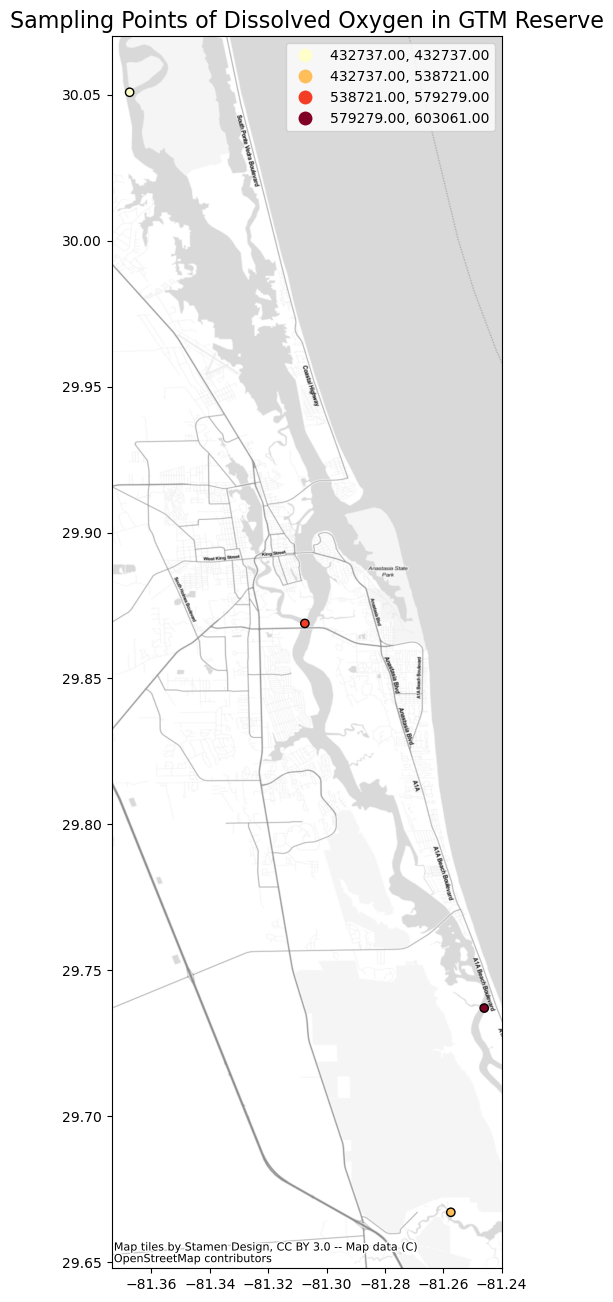

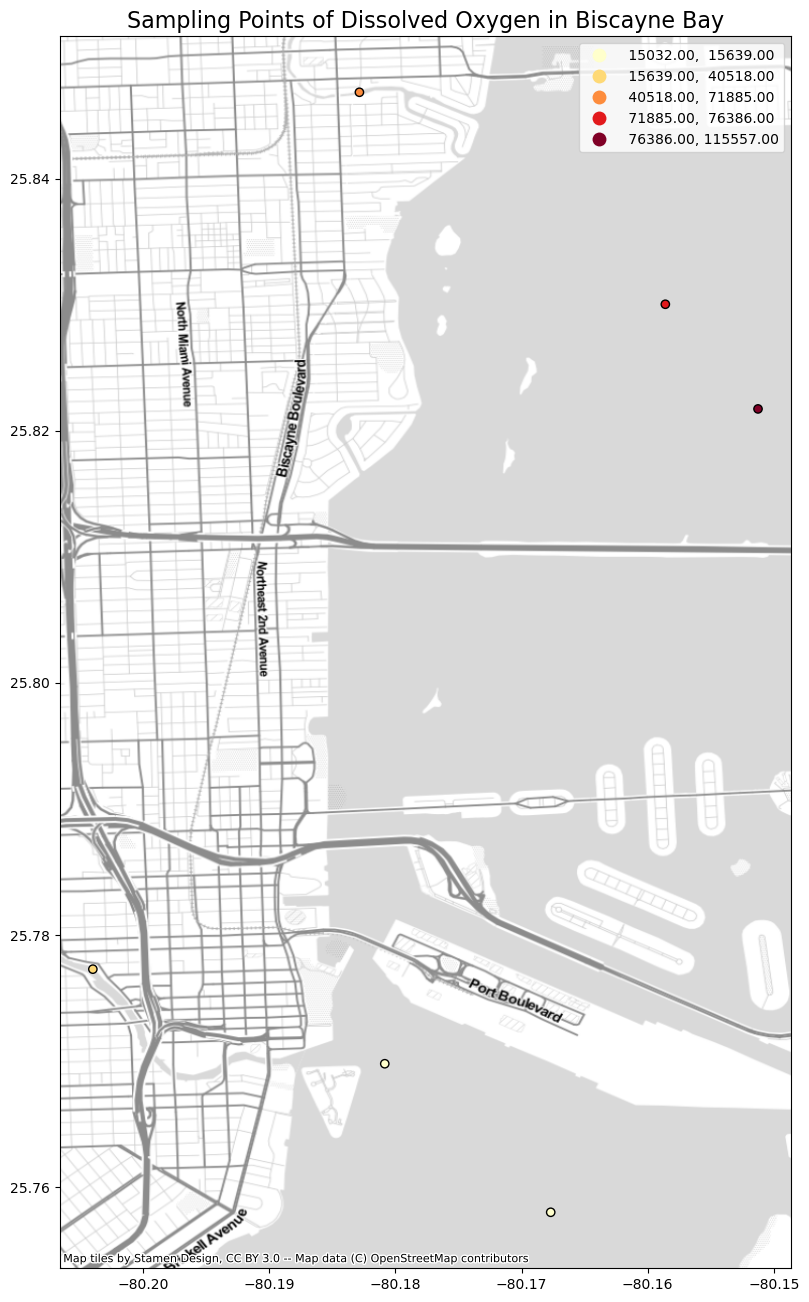

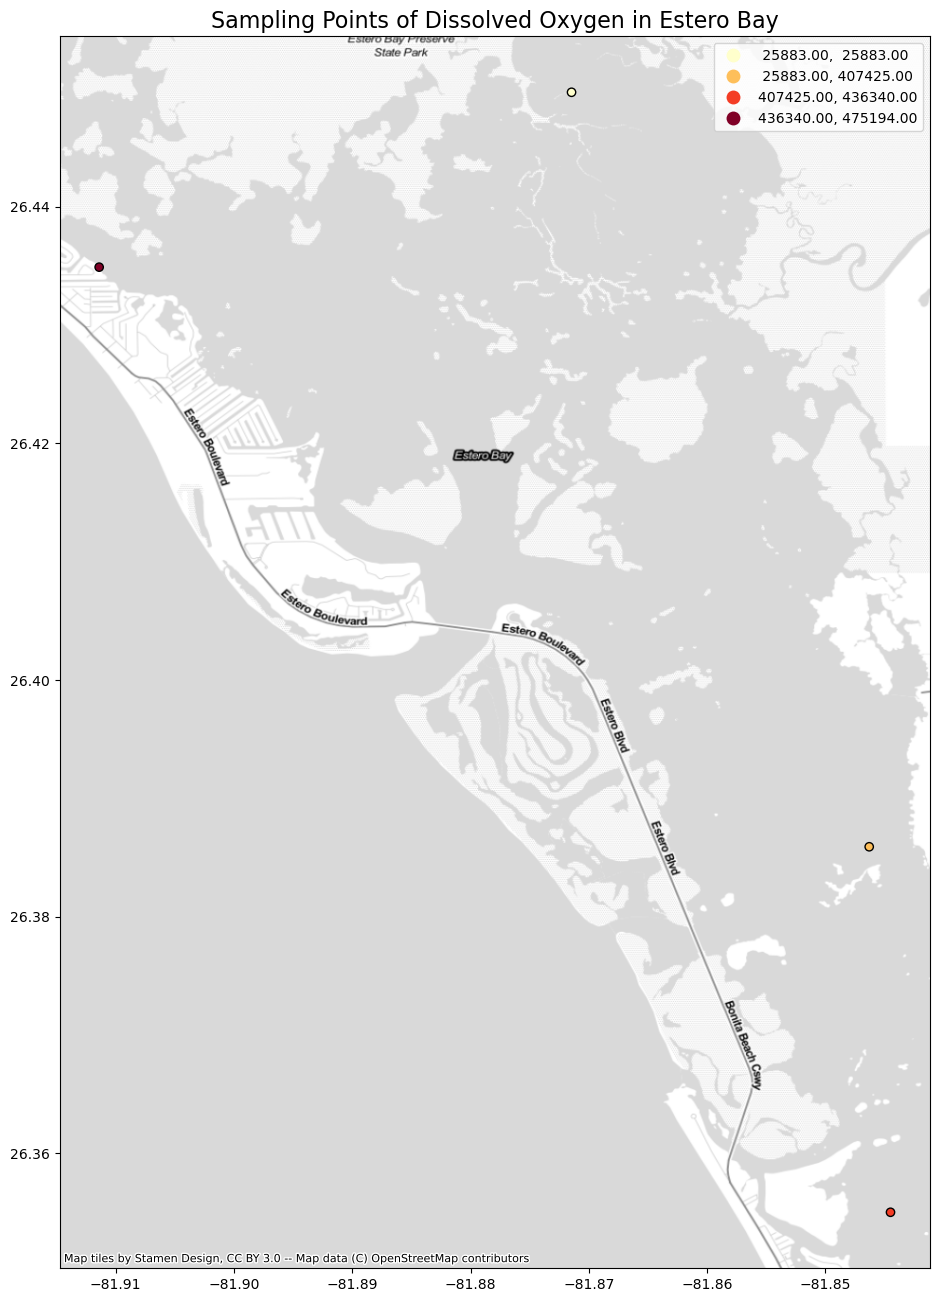

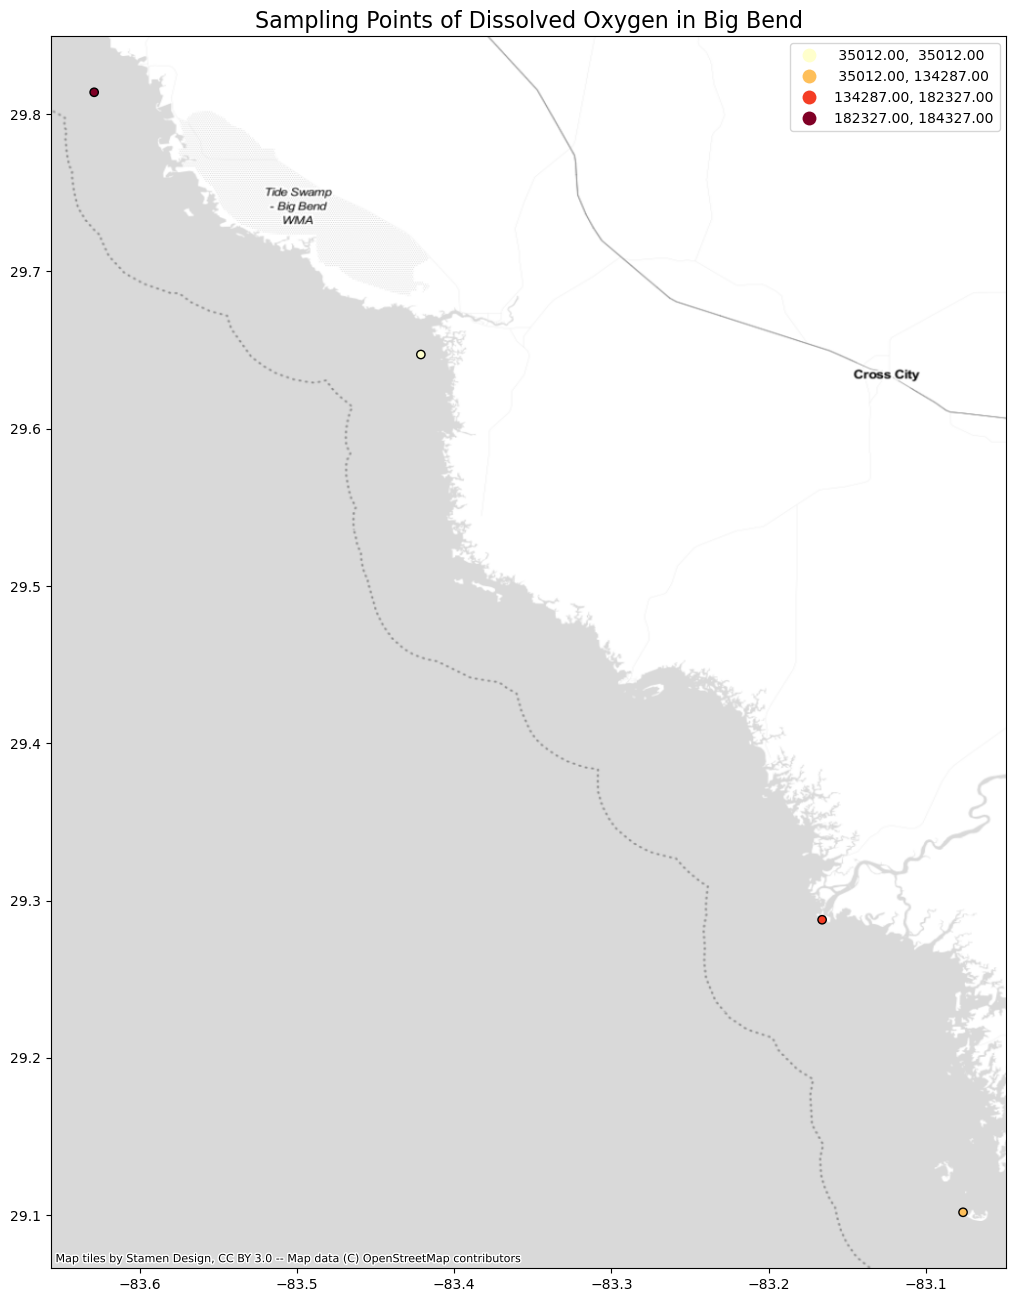

In [43]:
# select parameter and year
para = 'Dissolved Oxygen'

gdfLocPara = gdfLoc[gdfLoc['ParameterName']==para]

fig = plt.figure(figsize = (20, 15))

# This step is to depict the figure about fixed points and random points in each area.
for area in listArea:
    areaPoint = gdfLocPara[gdfLocPara["ManagedAreaName"] == area]
    if areaPoint["ParameterName"].count() != 0:
        #ax = areaPoint.plot(marker="o",facecolors='none', edgecolors='r',markersize=areaPoint['samples'])
        ax = areaPoint.plot(column ='samples',k=5,cmap="YlOrRd", scheme = 'NaturalBreaks',legend=True,
                           marker="o",facecolors='none', edgecolors='black'
        #                         ,markersize=areaPoint['samples']**(1/2)*8
                           )
        ax.set_title("Sampling Points of {} in {}".format(para,str(dictArea[area])),size=16)
        cx.add_basemap(ax,source=cx.providers.Stamen.TonerLite,crs=areaPoint.crs)
        #cx.add_basemap(ax,source=cx.providers.CartoDB.Positron,crs=gdf_Salinity.crs)


### 3.2 Spatial distribution of sampling locations of Dissolved Oxygen in 2019

First, aggregate data by location, parameter name, managed area, year and month.

In [45]:
# Aggregate data
dfLoc_m  = df2.groupby(['Latitude_DD','Longitude_DD',"ParameterName","ManagedAreaName","Year","Month"])["ResultValue"].agg("count").reset_index()

dfLoc_m = dfLoc_m.rename(columns={"ResultValue": "samples"})

dfLoc_m.loc[dfLoc_m["samples"] == 1,['sample_type']] ='Random Point'
dfLoc_m.loc[dfLoc_m["samples"] > 1,['sample_type']] ='Fixed Point'

# Convert the data to GeoDataFrame
gdfLoc_m = gpd.GeoDataFrame(dfLoc_m, geometry = gpd.points_from_xy(dfLoc_m.Longitude_DD, dfLoc_m.Latitude_DD),crs="EPSG:4326")

Plot fixed and random sampling location in each managed aera

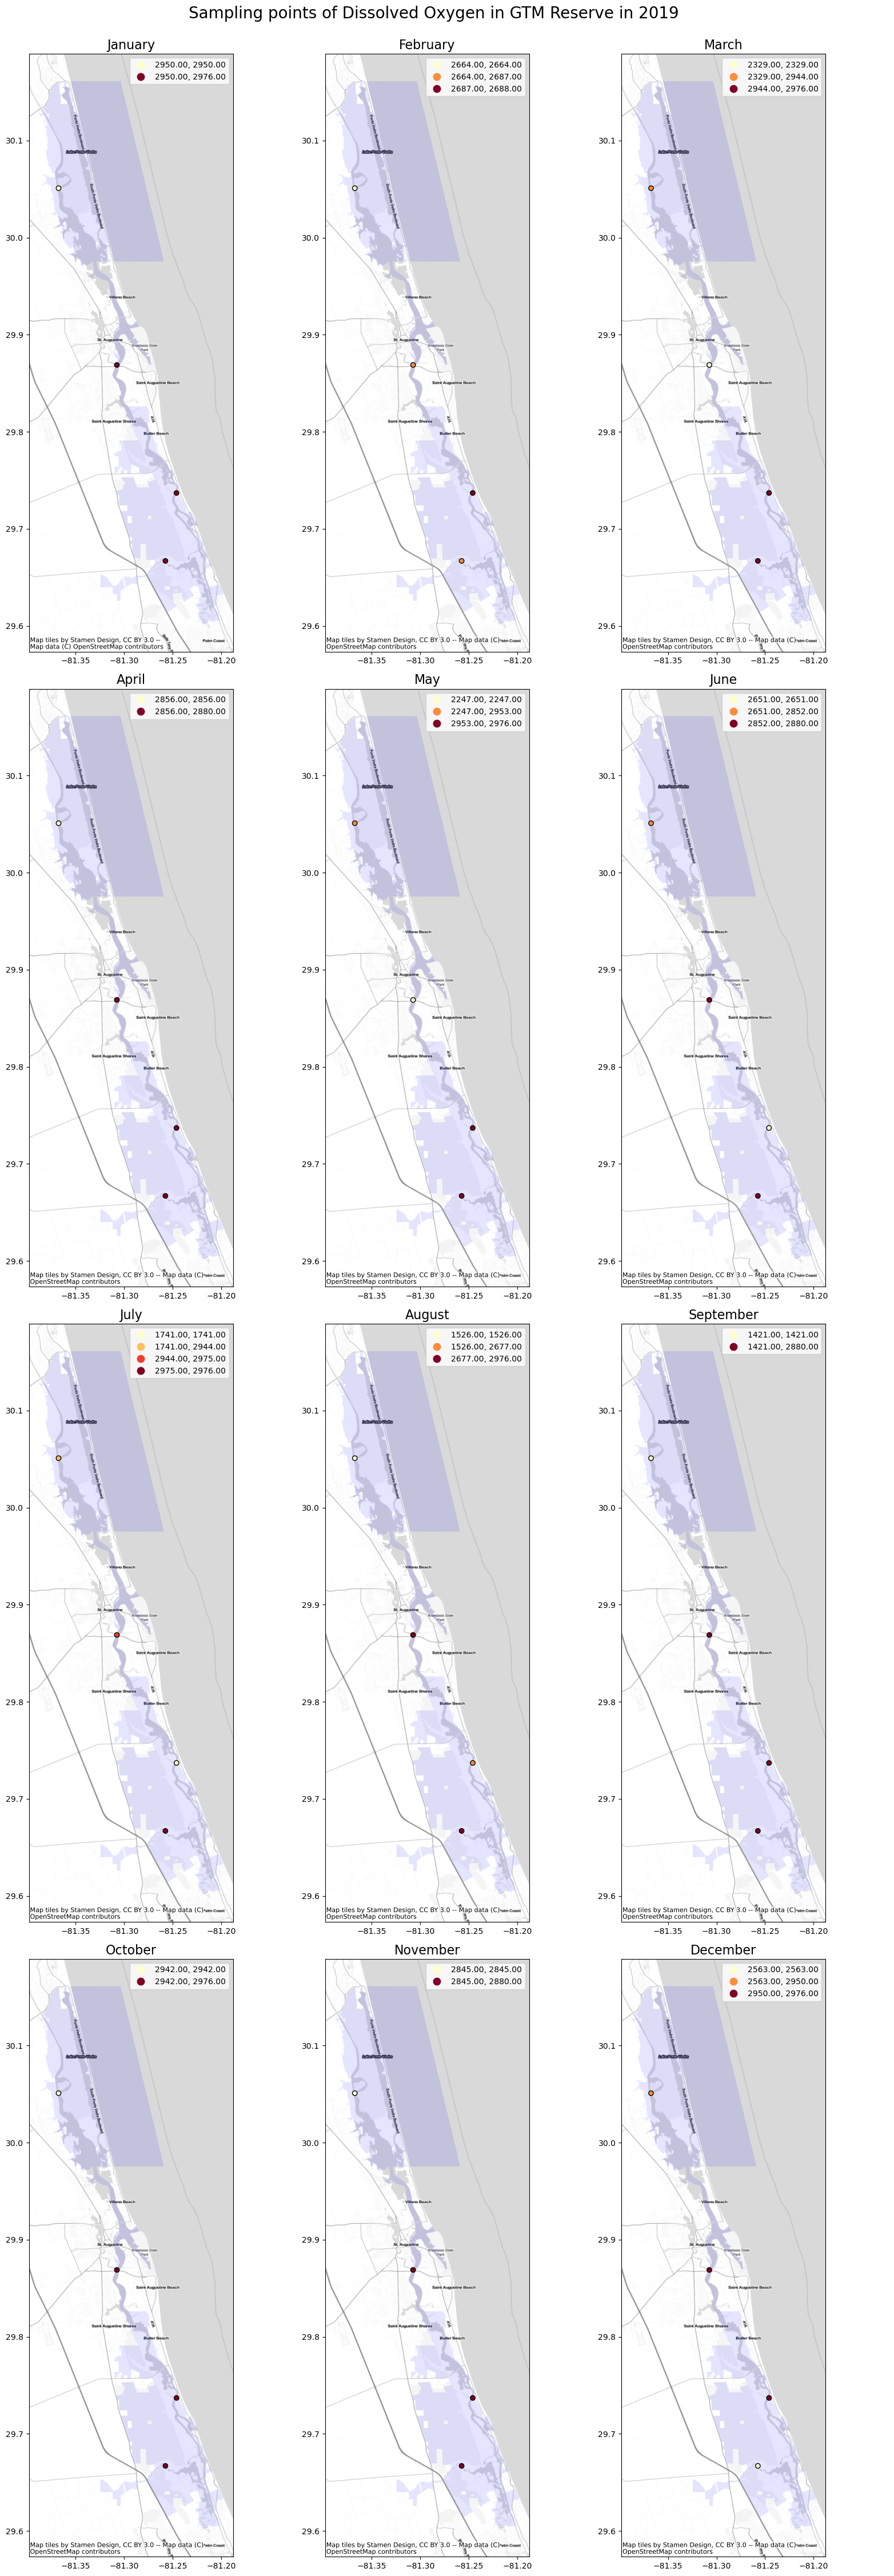

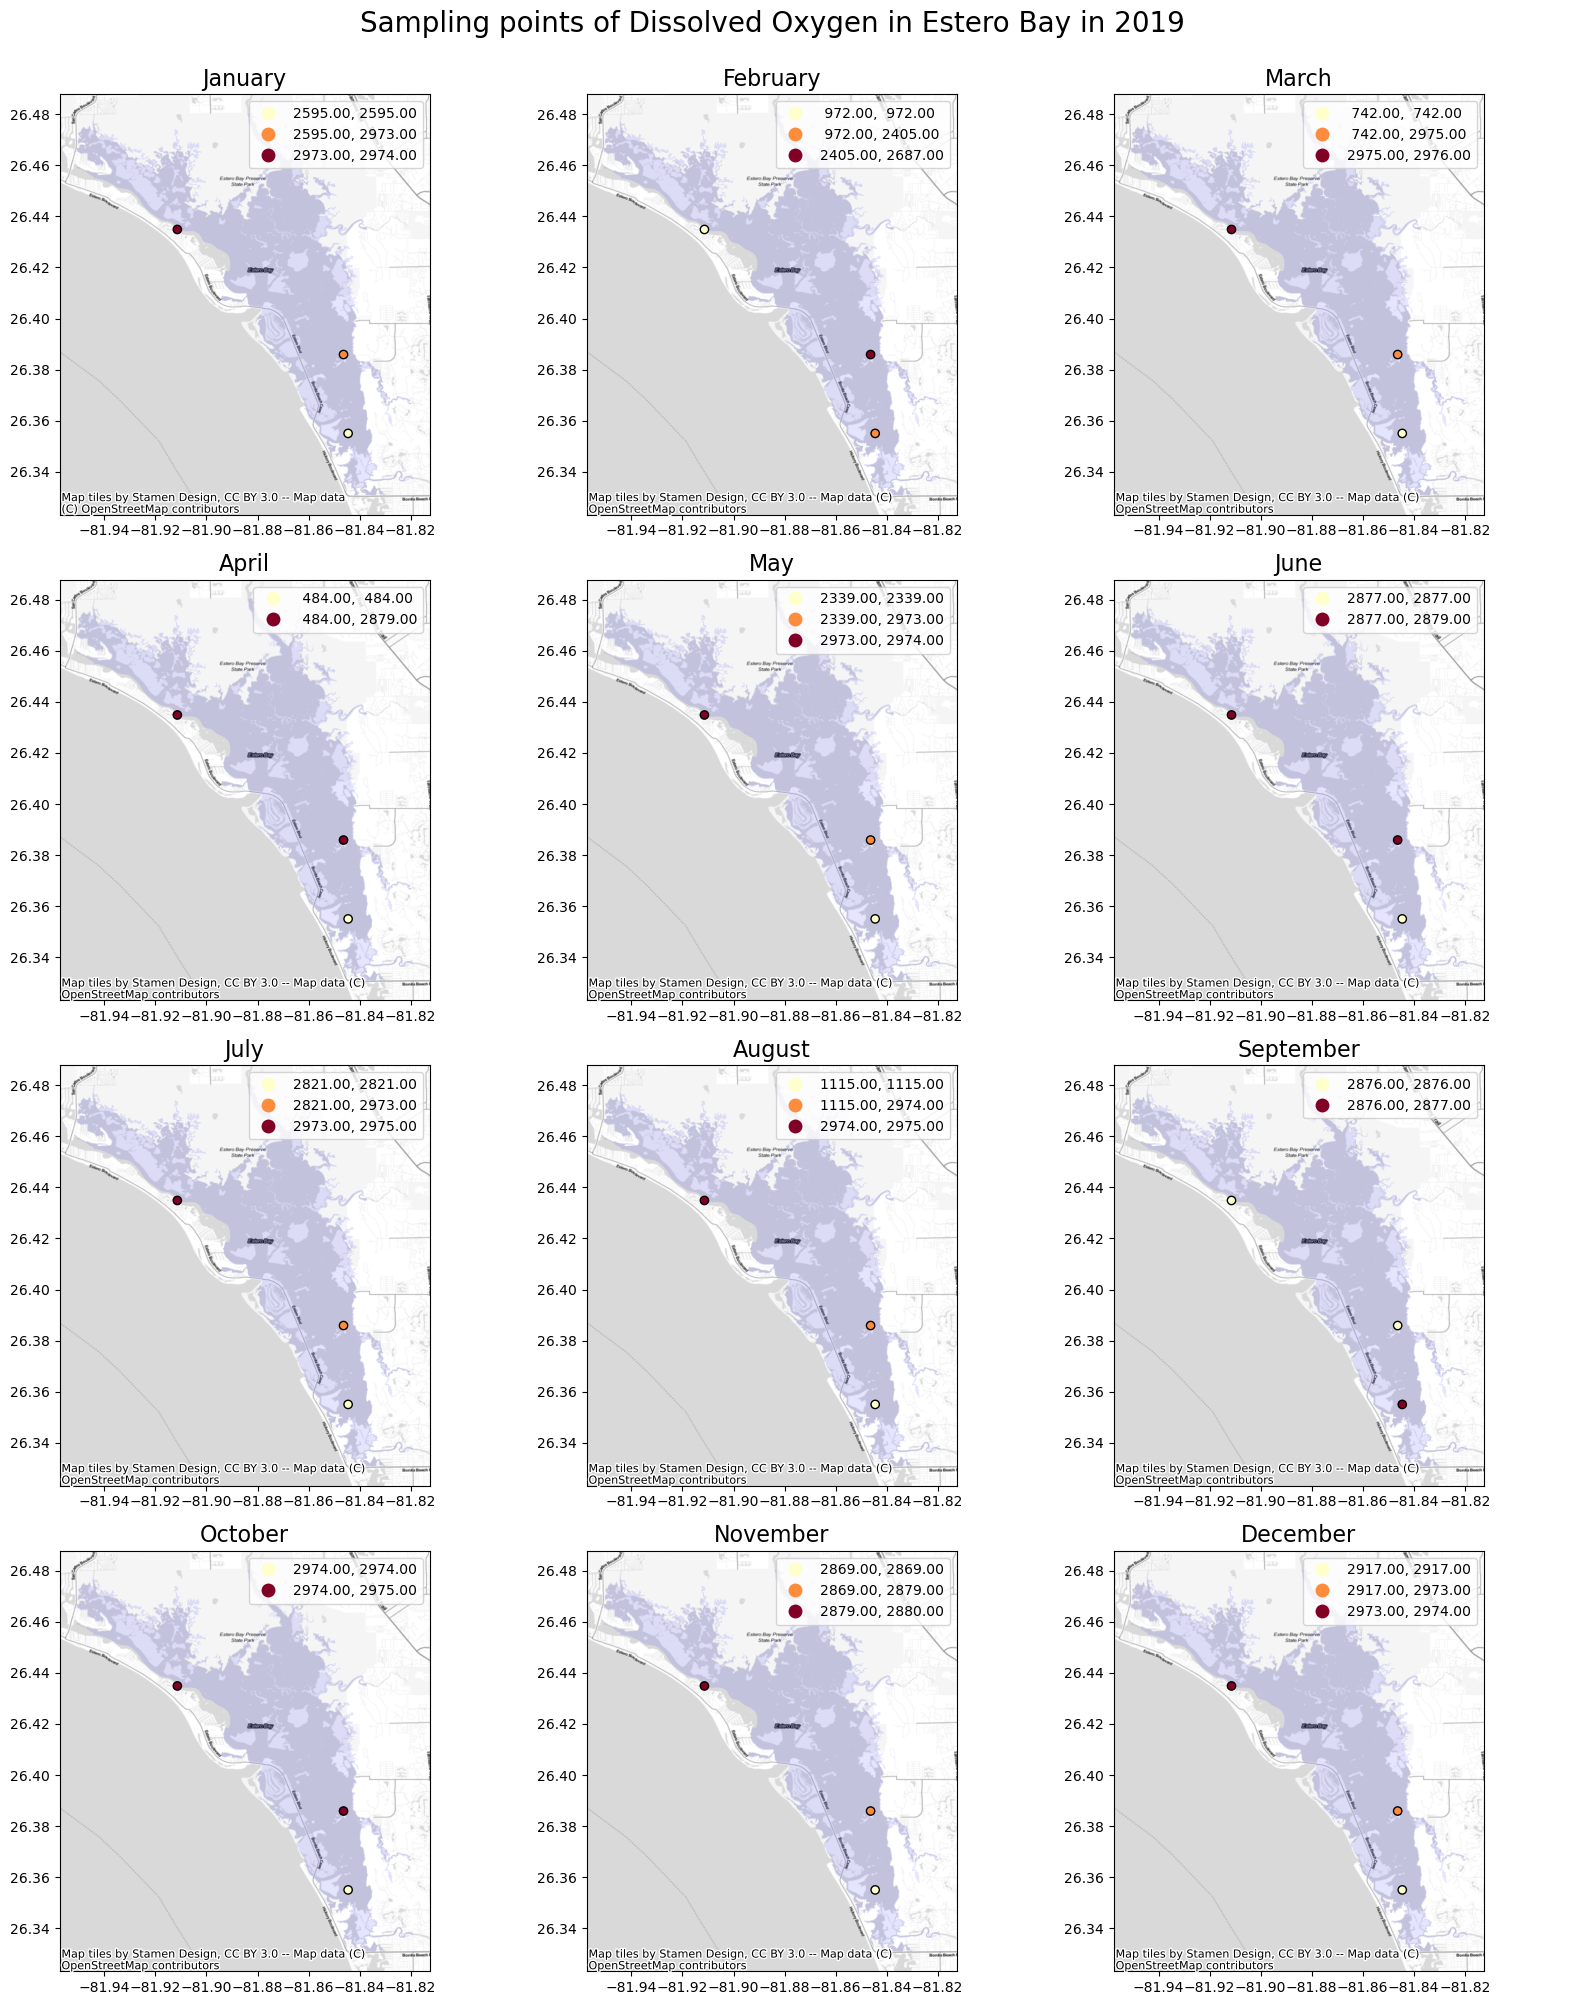

In [70]:
# Select Year and Parameter for the mapping
para, year = 'Dissolved Oxygen', 2019
for area in [listArea[0],listArea[2]]:
#    area = listArea[1]
    
    gdfLocPara = gdfLoc_m[(gdfLoc_m['ParameterName']==para)&(gdfLoc_m["Year"]==year)&(gdfLoc_m["ManagedAreaName"]==area)]
    areaSelect = areaShp[areaShp["LONG_NAME"]==area]

    
    row, col = 4, 3
    fig, axs = plt.subplots(row,col)
    plt.suptitle("Sampling points of {} in {} in {}".format(para, dictArea[area], year), fontsize = 20, y = 1)
    
    if dictArea[area] == 'GTM Reserve' or dictArea[area] == 'Biscayne Bay':
        fig.set_size_inches(16,45)
    else:
        fig.set_size_inches(16,20)
    
    i= 1 
    for r in range(0,row):
        for c in range(0,col):
            # Plot polygon of managed area
            areaSelect.plot(facecolor='blue',edgecolor='none',alpha = 0.1,ax=axs[r,c])
            # Select points by month
            areaPoint = gdfLocPara[gdfLocPara["Month"]==i]
#             print(str(areaPoint["ParameterName"].count())+" "+area)
            if areaPoint["ParameterName"].count() != 0:
                areaPoint.plot(column = 'samples' , k = 5, cmap = "YlOrRd", 
                               scheme = 'natural_breaks', marker = "o",
    #                            markersize=areaPoint['samples']**(1)*32,
                               edgecolors='black', legend=True,ax=axs[r,c])
                axs[r,c].set_title(dictMonth[i],size=16)

                cx.add_basemap(axs[r,c],source=cx.providers.Stamen.TonerLite,crs="EPSG:4326")
                plt.subplots_adjust(left=None, right=None, bottom=None, top=None, hspace=0, wspace=0)
                plt.tight_layout()

                plt.show

                if i > 12:
                    break
                else:
                    i = i+1

### 3.3 Sampling locations of Salinity in managed areas in 2019

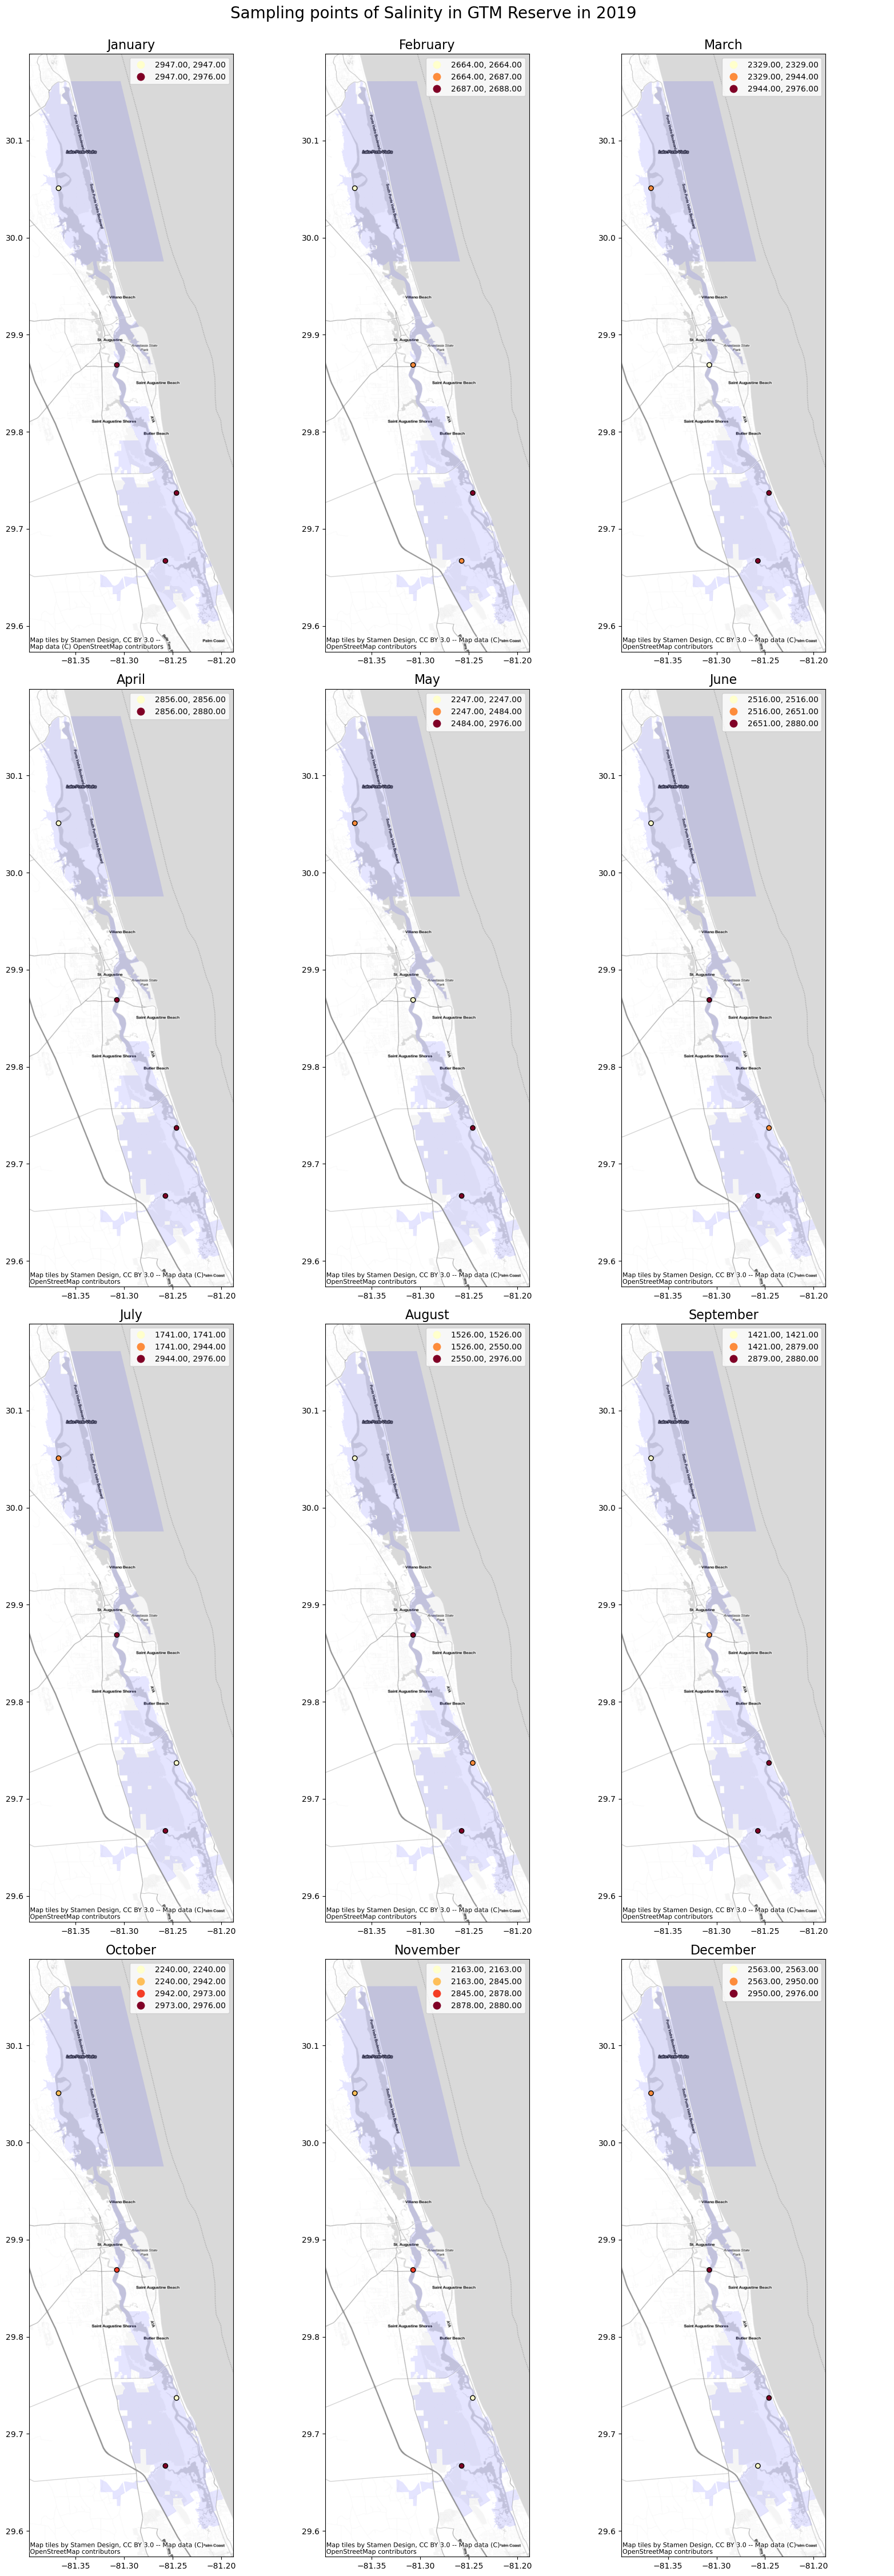

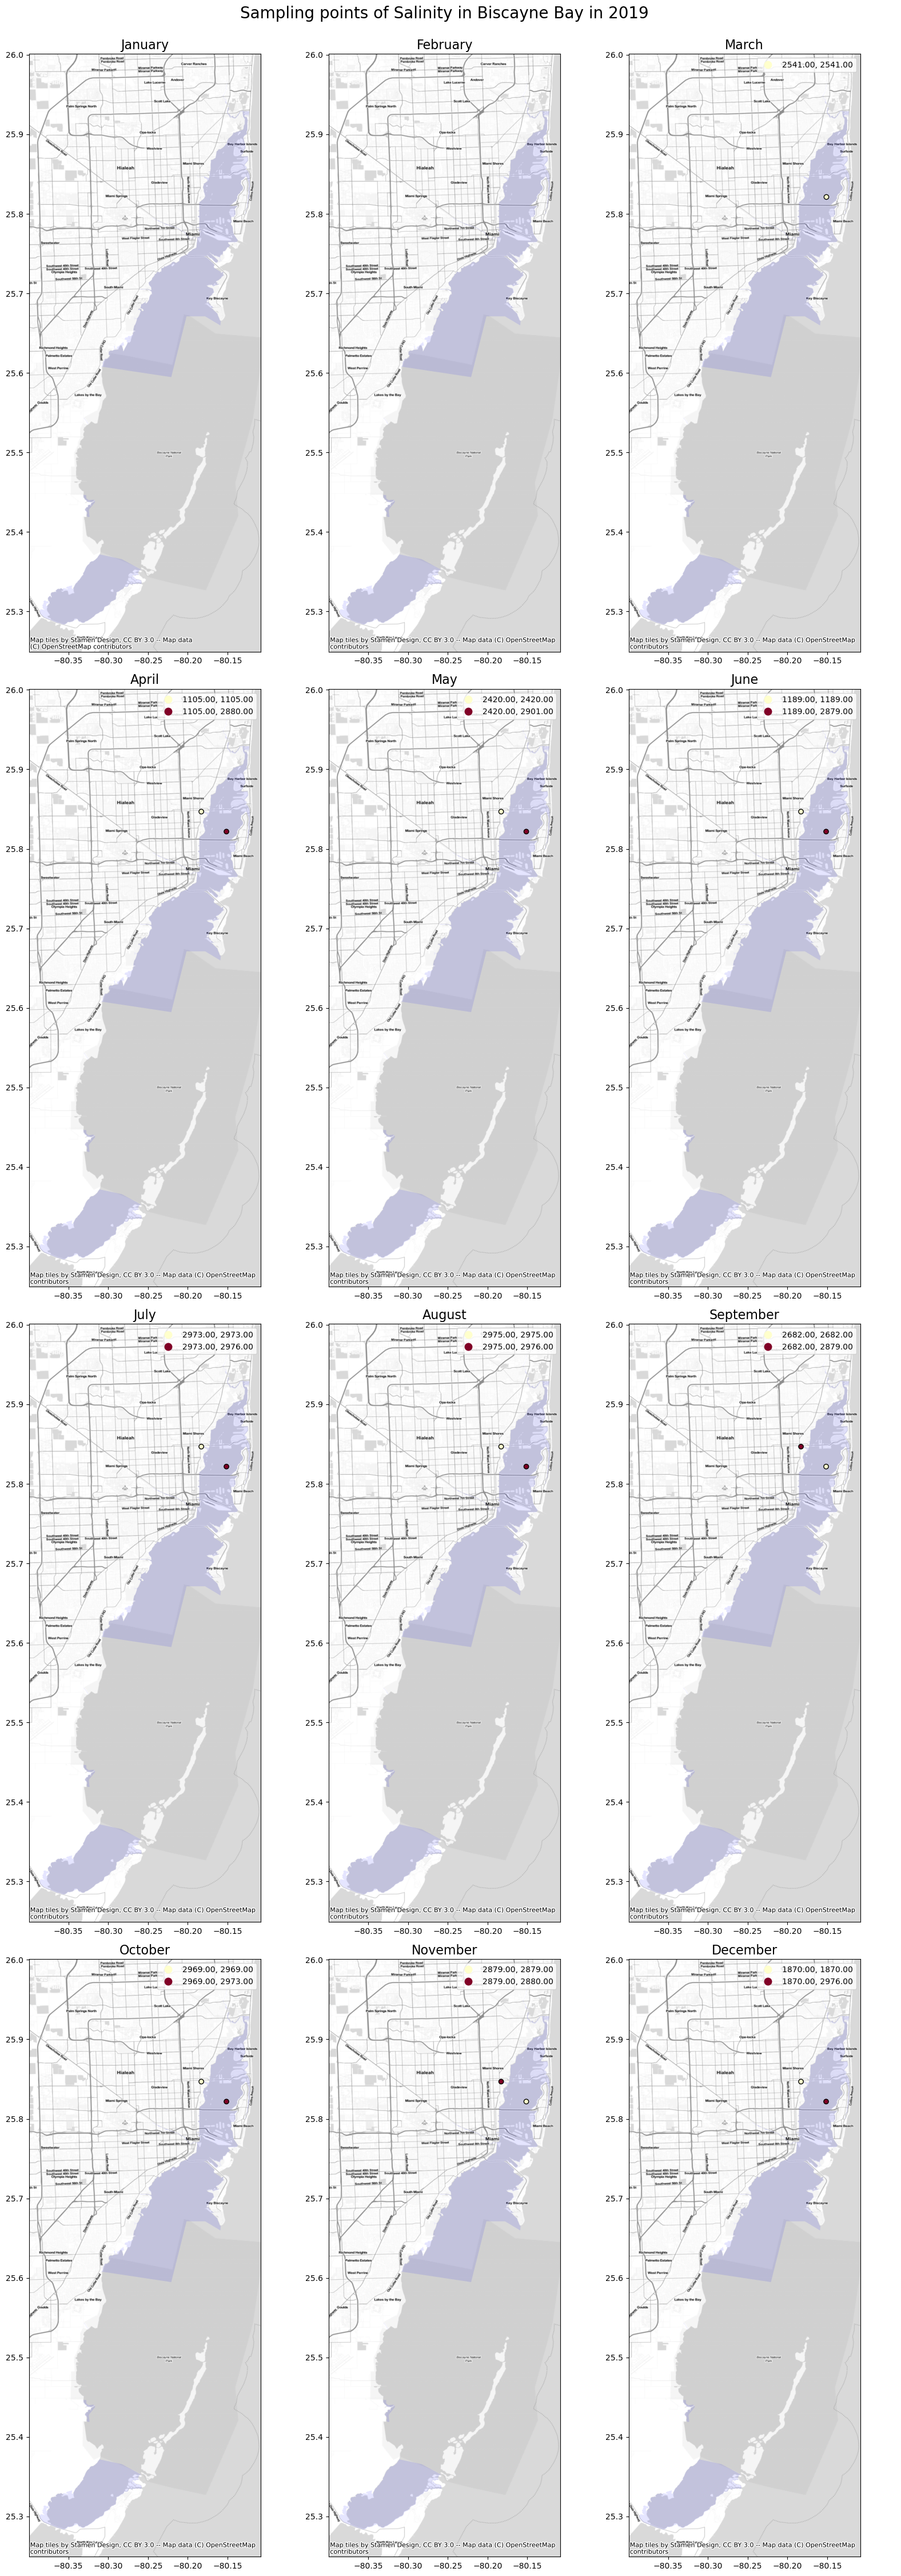

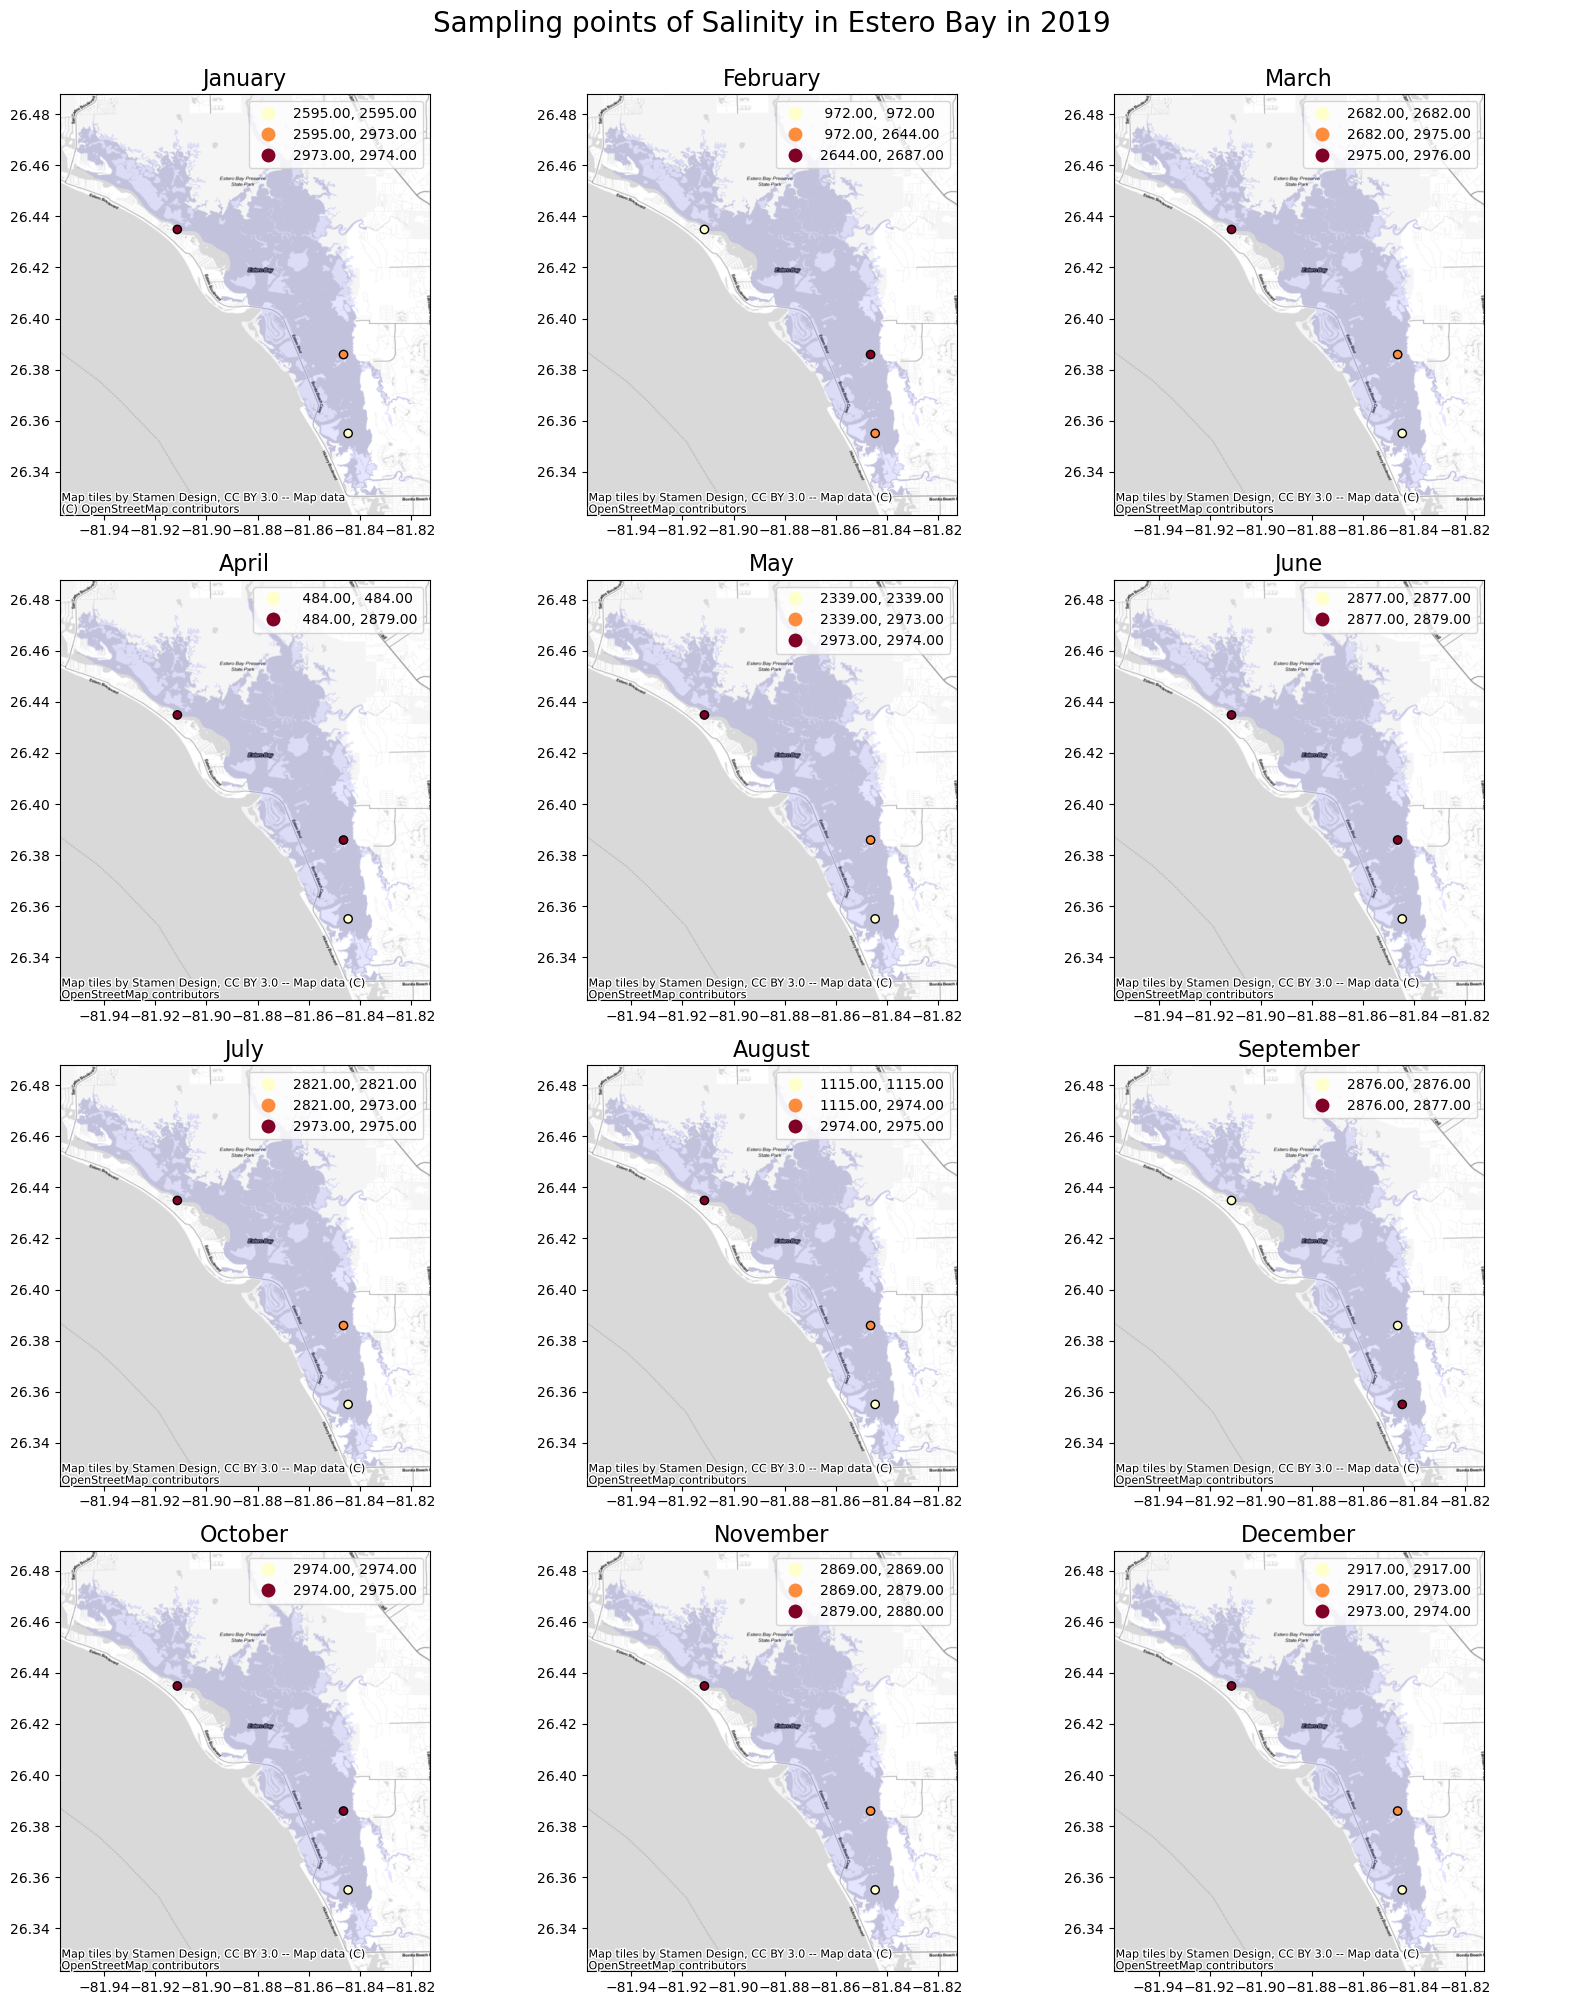

In [75]:
# Select Year and Parameter for the mapping
para, year = 'Salinity', 2019
for area in listArea[0:3]:
#    area = listArea[1]
    
    gdfLocPara = gdfLoc_m[(gdfLoc_m['ParameterName']==para)&(gdfLoc_m["Year"]==year)&(gdfLoc_m["ManagedAreaName"]==area)]
    areaSelect = areaShp[areaShp["LONG_NAME"]==area]

    row, col = 4, 3
    fig, axs = plt.subplots(row,col)
    plt.suptitle("Sampling points of {} in {} in {}".format(para, dictArea[area],year), fontsize = 20, y = 1)
    
    # Choose different layout for different managed areas
    if dictArea[area] == 'GTM Reserve' or dictArea[area] == 'Biscayne Bay':
        fig.set_size_inches(16,45)
    else:
        fig.set_size_inches(16,20)
    
    i= 1 
    for r in range(0,row):
        for c in range(0,col):
            # Plot polygon of managed area
            areaSelect.plot(facecolor='blue',edgecolor='none',alpha = 0.1,ax=axs[r,c])
            # Select points by month
            areaPoint = gdfLocPara[gdfLocPara["Month"]==i]
            
            areaPoint.plot(column = 'samples' , k = 5, cmap = "YlOrRd", 
                           scheme = 'natural_breaks', marker = "o",
#                            ,markersize=areaPoint['samples']**(1)*32,
                           edgecolors='black', legend=True,ax=axs[r,c])
            axs[r,c].set_title(dictMonth[i],size=16)

            cx.add_basemap(axs[r,c],source=cx.providers.Stamen.TonerLite,crs="EPSG:4326")
            plt.subplots_adjust(left=None, right=None, bottom=None, top=None, hspace=0, wspace=0)
            plt.tight_layout()
            
            plt.show

            if i > 12:
                break
            else:
                i = i+1